<a href="https://colab.research.google.com/github/sahil301290/Deep-Learning/blob/master/RoBERTa_news_sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import the required libraries**

In [1]:
#Import required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,auc

!pip install transformers
import transformers
from transformers import RobertaConfig, RobertaModel
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 12,6

import warnings
warnings.filterwarnings('ignore')

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
!nvidia-smi

Fri May 20 03:48:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
df=pd.read_csv('/content/news_sentiment_data.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,date,articleid,headline,compound_vader_score,sentiment_class
0,0,0,1991-11-14 00:00:00+00:00,wsj_398284048,Banking Bill Negotiators Set Compromise --- Pl...,0.2960,1
1,1,1,1986-06-16 00:00:00+00:00,wsj_397959018,Manager's Journal: Sniffing Out Drug Abusers I...,-0.7003,0
2,2,2,2001-05-24 00:00:00+00:00,wsj_398739166,"Bank of Montreal, Royal Bank Profits Rose in 2...",0.4404,1
3,3,3,1986-10-22 00:00:00+00:00,wsj_397957465,Battle Over Medical Costs Isn't Over,-0.3818,0
4,4,4,2005-12-08 00:00:00+00:00,wsj_399004010,"Dow Falls 45.95, Late GM Surge Stanches Losses",-0.4019,0


In [4]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1','date','articleid','compound_vader_score'], axis=1)
df.head()

,headline,sentiment_class
0,Banking Bill Negotiators Set Compromise --- Pl...,1
1,Manager's Journal: Sniffing Out Drug Abusers I...,0
2,"Bank of Montreal, Royal Bank Profits Rose in 2...",1
3,Battle Over Medical Costs Isn't Over,0
4,"Dow Falls 45.95, Late GM Surge Stanches Losses",0


In [5]:
df.shape

(4846, 2)

In [6]:
Pre_trained_model='roberta-base'

In [7]:
from transformers import RobertaTokenizer

In [8]:
tokenizer = RobertaTokenizer.from_pretrained(Pre_trained_model)

In [9]:
token_lens=[]
for content in df.headline:
    tokens_content=tokenizer.encode(content,max_length=150,truncation=True)
    token_lens.append(len(tokens_content))

Text(0.5, 0, 'Token count')

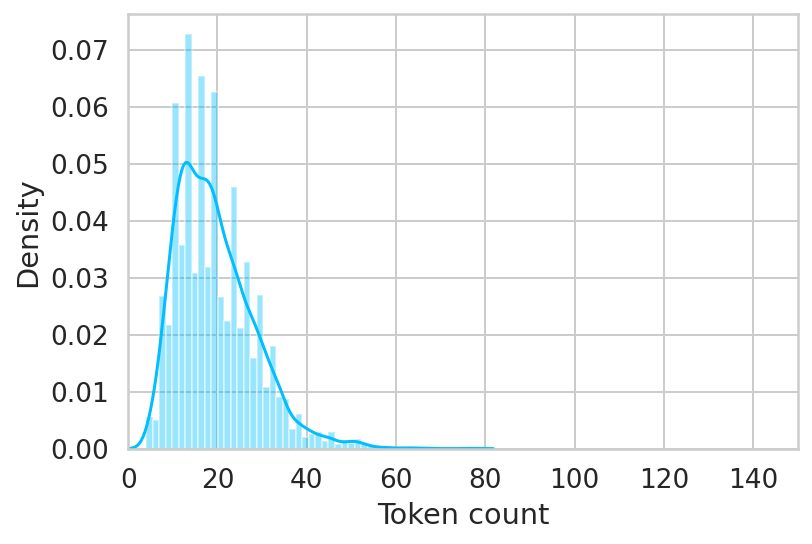

In [10]:
#Plot the tokens
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

In [11]:
Max_length=100

In [12]:
class reviews_headline(Dataset):

    def __init__(self,reviews,targets,tokenizer,max_length):
        self.reviews=reviews
        self.targets=targets
        self.tokenizer=tokenizer
        self.max_length=max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        targets = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            max_length=Max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
           )
        return {
            'review_text':review,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'targets' : torch.tensor(targets,dtype=torch.long)
        }

In [13]:
df_train,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_valid,df_test = train_test_split(df_test,test_size=0.5,random_state=42)

print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape}')
print(f'Testing dataset : {df_test.shape}')
print(f'Validation dataset : {df_valid.shape}')

Print the shape of datasets...
Training dataset : (3876, 2)
Testing dataset : (485, 2)
Validation dataset : (485, 2)


In [14]:
batch_size=32
def data_loader(df, tokenizer, max_length, batch):
    ds=reviews_headline(
      reviews=df.headline.to_numpy(),
      targets=df.sentiment_class.to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

    return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# Load datasets
train_DataLoader=data_loader(df_train,tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(df_test,tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_valid,tokenizer,Max_length,batch_size)

In [15]:
data=next(iter(train_DataLoader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [16]:
print('Shape of the data keys...')
print(f"Input_ids : {data['input_ids'].shape}")
print(f"Attention_mask : {data['attention_mask'].shape}")
print(f"targets : {data['targets'].shape}")

Shape of the data keys...
Input_ids : torch.Size([32, 100])
Attention_mask : torch.Size([32, 100])
targets : torch.Size([32])


In [17]:
roberta_model = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(Pre_trained_model,return_dict=False)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [19]:
model = SentimentClassifier(len(df.sentiment_class))         #Create an instance / object
model = model.to(device)                              # Move instance to GPU           

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 100])
torch.Size([32, 100])


In [21]:
epochs=5
optimizer=AdamW(model.parameters(),lr=2e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

In [22]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        #Feed data to RoBERTa model
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_observations, np.mean(losses)

In [23]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            # Feed data to RoBERTa model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_observations, np.mean(losses)

In [24]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [25]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_DataLoader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        valid_DataLoader,
        device,
        loss_fn,
        len(df_valid)
      )
    print(f'Validation  loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 1.4220573975414526 accuracy 0.5103199174406604
Validation  loss 0.5509532522410154 accuracy 0.7587628865979381

Epoch 2/5
----------
Train loss 0.4948767008351498 accuracy 0.7801857585139318
Validation  loss 0.31789007876068354 accuracy 0.865979381443299

Epoch 3/5
----------
Train loss 0.281336743079248 accuracy 0.8924148606811145
Validation  loss 0.31357666989788413 accuracy 0.8721649484536083

Epoch 4/5
----------
Train loss 0.19974117532189264 accuracy 0.9308565531475748
Validation  loss 0.3104839716106653 accuracy 0.8907216494845361

Epoch 5/5
----------
Train loss 0.1371212812507006 accuracy 0.9574303405572755
Validation  loss 0.30879359832033515 accuracy 0.9051546391752577

CPU times: user 5min 24s, sys: 11.3 s, total: 5min 35s
Wall time: 5min 45s


In [26]:
history['train_acc']

[tensor(0.5103, device='cuda:0', dtype=torch.float64),
 tensor(0.7802, device='cuda:0', dtype=torch.float64),
 tensor(0.8924, device='cuda:0', dtype=torch.float64),
 tensor(0.9309, device='cuda:0', dtype=torch.float64),
 tensor(0.9574, device='cuda:0', dtype=torch.float64)]

In [27]:
history['train_acc'][0]

tensor(0.5103, device='cuda:0', dtype=torch.float64)

In [28]:
history['train_acc'][0].item()

0.5103199174406604

In [29]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for i in range(5):
  train_acc.append(history['train_acc'][i].item())
  train_loss.append(history['train_loss'][i].item())
  val_acc.append(history['val_acc'][i].item())
  val_loss.append(history['val_loss'][i].item())
print(train_acc)
print(train_loss)
print(val_acc)
print(val_loss)

[0.5103199174406604, 0.7801857585139318, 0.8924148606811145, 0.9308565531475748, 0.9574303405572755]
[1.4220573975414526, 0.4948767008351498, 0.281336743079248, 0.19974117532189264, 0.1371212812507006]
[0.7587628865979381, 0.865979381443299, 0.8721649484536083, 0.8907216494845361, 0.9051546391752577]
[0.5509532522410154, 0.31789007876068354, 0.31357666989788413, 0.3104839716106653, 0.30879359832033515]


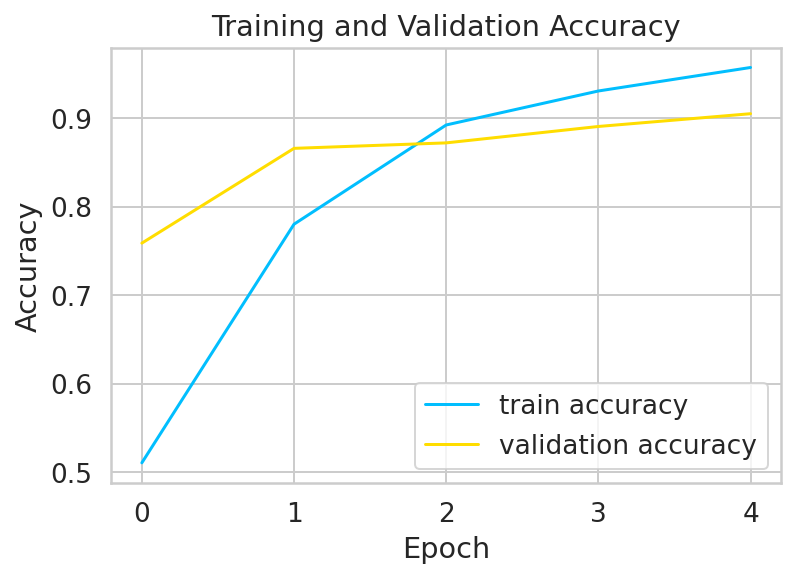

In [30]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

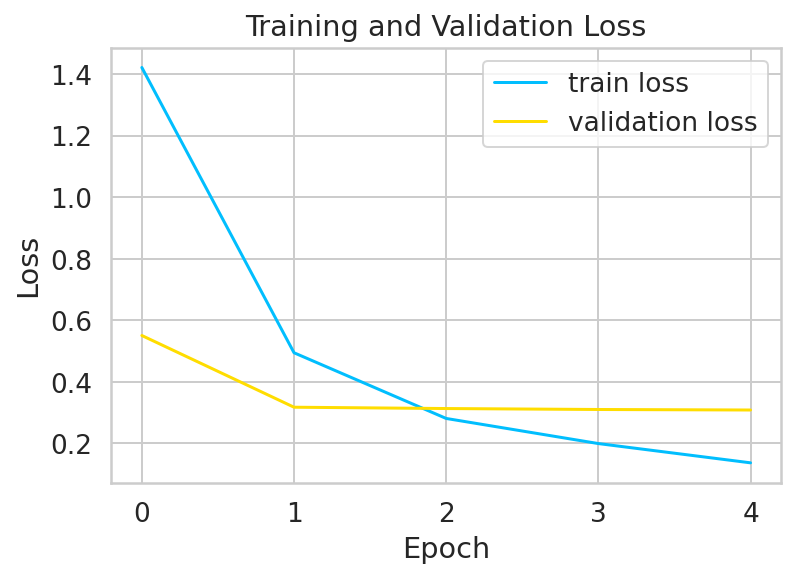

In [31]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [32]:
test_acc, _ = eval_model(
  model,
  test_DataLoader,
  device,
  loss_fn,
  len(df_test)
)

In [33]:
test_acc.item()

0.8824742268041237

In [34]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [35]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_DataLoader
)

In [36]:
df.columns

Index(['headline', 'sentiment_class'], dtype='object')

In [37]:
class_report=classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       218
           1       0.91      0.87      0.89       267

    accuracy                           0.88       485
   macro avg       0.88      0.88      0.88       485
weighted avg       0.88      0.88      0.88       485



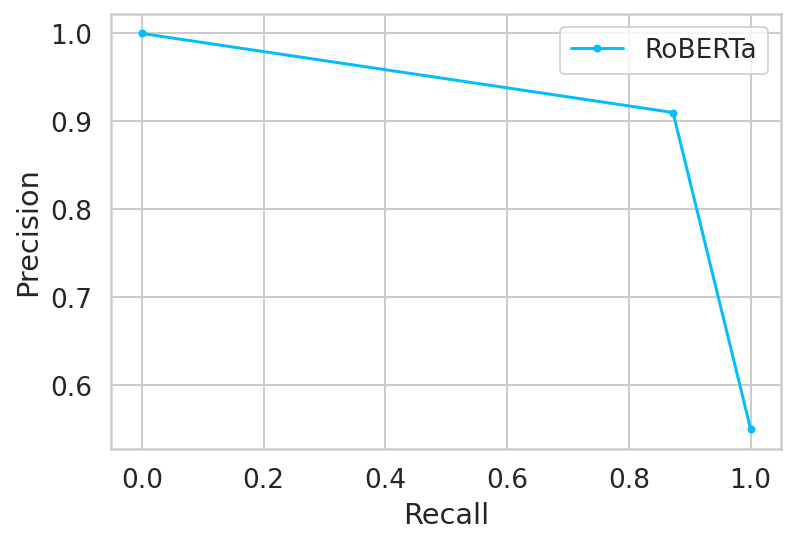

In [38]:
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='RoBERTa')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
#Calculate AUC_score for PR curve
auc_score = auc(recall, precision)
print('PR AUC_score: %.3f' % auc_score)

PR AUC_score: 0.926


In [40]:
path="./Sentiment_Analysis_RoBerta.bin"
torch.save(model.state_dict(),path)